In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import random
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
from IPython import display
import time
from pathlib import Path
import pandas as pd
import os
import copy
import networkx as nx
import pickle
import sys
from scipy import stats
%matplotlib inline

In [2]:
# Change directory to where packages are stored
os.chdir("..")

# and import packages
from pyanimats import *
from pyTPM import *
import actual_agency as agency
import pyphi
from pyphi import actual, config, Direction

pyphi.config.VALIDATE_SUBSYSTEM_STATES = False
pyphi.config.PARTITION_TYPE = 'TRI'


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [3]:
# Change directory back to Example directory
os.chdir("Example")

In [4]:
%load_ext autoreload
%autoreload 2
%aimport pyTPM, pyanimats, actual_agency

# Lets inspect the fitness of the animats

In [5]:
# defining some parameters to use 
generations = 1000
n_agents = int(generations/500.+1)
n_runs = 5
n_trials = 64

run = 0
agent = 2
trial = 5
transition = 10

In [6]:
# Get Line-of-descent (LOD) data from MABE output
with open('LOD_data.pkl','rb') as f:
    LOD_data = pickle.load(f)

In [7]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print(cwd)

/home/kyoko/デスクトップ/Develop/ActualCausation/MABE/MABE_contents/actual_agency/Example


In [8]:
# inspect the Line-of-descent (LOD) data
LOD_data[0]

,update,timeToCoalescence,ID,alive,correct_AVE,correct_LIST,genomeLength,incorrect_AVE,incorrect_LIST,markovBrainDeterministicGates,markovBrainGates,markovBrain_nextNodesConnections_AVE,markovBrain_nextNodesConnections_LIST,markovBrain_nodesConnections_AVE,markovBrain_nodesConnections_LIST,optimizeValue,score_AVE,score_LIST,timeOfBirth
0,0,0,23,1,31.0,31,5000,33.0,33,2,2,0.625,"0,0,1,1,0,2,0,1",0.625,"1,0,1,0,0,0,1,2",0.907029,0.907029,0.907029,-1
1,500,0,50012,1,49.0,49,14509,15.0,15,3,3,1.125,"0,0,4,1,0,1,1,2",1.375,"3,2,1,1,0,0,2,2",5.253348,5.253348,5.253348,499
2,1000,135,100042,1,49.0,49,17675,15.0,15,4,4,1.250,"0,2,2,5,0,0,0,1",1.375,"3,1,0,0,2,2,0,3",5.253348,5.253348,5.253348,999


In [9]:
# add fitness to the LOD data structure

for n in range(n_runs):
    LOD_data[n]['fitness'] = (LOD_data[n]['correct_AVE']
                               /(LOD_data[n]['correct_AVE']+LOD_data[n]['incorrect_AVE']))

In [10]:
# inspect the fitness of a specific LOD (run)
heading = 'fitness'
LOD_data[run][heading][:]


0    0.484375
1    0.765625
2    0.765625
Name: fitness, dtype: float64

In [11]:
# and write the values to a new list
fitness_data = [[LOD_data[r][heading][i] for i in range(n_agents)] for r in range(n_runs)]
[print(x) for x in fitness_data]

[0.484375, 0.765625, 0.765625]
[0.484375, 0.734375, 0.75]
[0.453125, 0.765625, 0.765625]
[0.484375, 0.765625, 0.765625]
[0.484375, 0.796875, 0.796875]


[None, None, None, None, None]

# Now let's look at the genome data

In [12]:

# Get the genome from our output
with open('genome.pkl','rb') as f:
    all_genomes = pickle.load(f)
    


In [13]:
all_genomes[run]

,GENOME_root::_genomeLength,GENOME_root::_sites,ID,update
0,5000,"243,244,3,151,30,196,44,49,56,51,247,225,38,20...",23,0
1,14509,"177,173,3,141,30,89,243,113,161,175,242,164,19...",50012,500
2,17675,"140,22,242,212,189,123,107,98,161,176,75,78,25...",100042,1000


In [14]:
# we can pick the genome of one agent and parse it (make it readable for our scripts) 
genome = agency.get_genome(all_genomes, run, agent)

# from the genome we can reconstruct the TPM (transition probability matrix) and CM (connectivity matrix)
TPM, TPM_gates, cm = genome2TPM(genome, n_nodes=8, n_sensors=2, n_motors=2, gate_type='deterministic',states_convention='loli',remove_sensor_motor_effects=True)


In [15]:
# then we can inspect the TPM
[print(x) for x in TPM] 

[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  0.  0.  0.  0.  0. ]
[0.5 0.5 1.  1.  0.  0.  0.  1. ]
[0.5 0.5 1.  0.  0.  0.  0.  1. ]
[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  0.  0.  0.  0.  0. ]
[0.5 0.5 1.  1.  0.  0.  0.  1. ]
[0.5 0.5 1.  0.  0.  0.  0.  1. ]
[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  0.  0.  0.  0.  0. ]
[0.5 0.5 1.  1.  0.  0.  0.  1. ]
[0.5 0.5 1.  0.  0.  0.  0.  1. ]
[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  0.  0.  0.  0.  0. ]
[0.5 0.5 1.  1.  0.  0.  0.  1. ]
[0.5 0.5 1.  0.  0.  0.  0.  1. ]
[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  1.  0.  0.  0.  1. ]
[0.5 0.5 1.  1.  0.  0.  0.  1. ]
[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  1.  0.  0.  0.  1. ]
[0.5 0.5 1.  1.  0.  0.  0.  1. ]
[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  1.  0.  0.  0.  1. ]
[0.5 0.5 1.  1.  0.  0.  0.  1. ]
[0.5 0.5 1.  1.  0.  0.  0.  0. ]
[0.5 0.5 1.  1

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [16]:
# the gate specific TPMS
TPM_gates

[{'type': 'deterministic',
  'ins': array([4]),
  'outs': array([1]),
  'logic': [[1.0], [1.0]]},
 {'type': 'deterministic',
  'ins': array([7, 0, 5, 1]),
  'outs': array([2, 7]),
  'logic': [[1.0, 0.0],
   [0.0, 1.0],
   [1.0, 0.0],
   [1.0, 1.0],
   [1.0, 0.0],
   [0.0, 1.0],
   [1.0, 1.0],
   [1.0, 1.0],
   [1.0, 1.0],
   [1.0, 1.0],
   [1.0, 1.0],
   [1.0, 1.0],
   [1.0, 0.0],
   [1.0, 1.0],
   [0.0, 1.0],
   [1.0, 1.0]]},
 {'type': 'deterministic',
  'ins': array([4, 0, 7]),
  'outs': array([1, 3]),
  'logic': [[1.0, 1.0],
   [0.0, 1.0],
   [1.0, 0.0],
   [0.0, 1.0],
   [1.0, 1.0],
   [1.0, 1.0],
   [1.0, 1.0],
   [0.0, 1.0]]},
 {'type': 'deterministic',
  'ins': array([5, 0, 7]),
  'outs': array([3]),
  'logic': [[1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]}]

In [17]:
# and also the connectivity matrix (CM)
print(cm)

[[0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]]


# Last part of the output is the activity pattern

In [18]:
# First get the data from our MABE output
with open('activity.pkl','rb') as f:
    activity = pickle.load(f)
    

In [19]:
# reformat the activity to a single list for each trial
brain_activity = []
for r in range(n_runs):
    brain_activity.append(agency.getBrainActivity(activity[r], n_agents))

Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...


In [20]:
# inspect activity for a given run, agent, and trial

print(brain_activity[run][agent][trial])

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]]


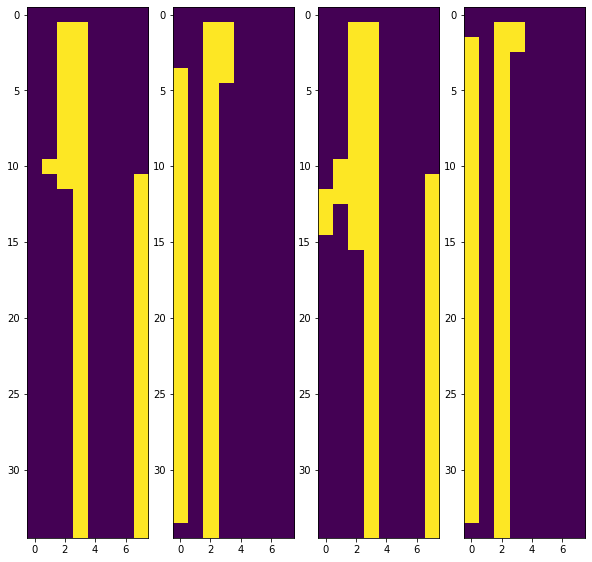

In [21]:
# plotting activity of the wait'th trial of each trial type
wait = 4

plt.figure(figsize=(10,10))
plt.subplot(1,4,1)
plt.imshow(brain_activity[run][agent][0+wait])
plt.subplot(1,4,2)
plt.imshow(brain_activity[run][agent][16+wait])
plt.subplot(1,4,3)
plt.imshow(brain_activity[run][agent][32+wait])
plt.subplot(1,4,4)
plt.imshow(brain_activity[run][agent][48+wait])

# The next step is doing some actual causation analysis

In [22]:
# let's analyse the actual causes of the motor occurences for the animat in one trial

# First we can inspect the occurrences
X,Y = agency.get_occurrences(np.array(brain_activity[run][agent]),numSensors=2,numHidden=4,numMotors=2)
print('transition from {} to {}'.format(X[trial][transition],Y[trial][transition]))

transition from [0. 0. 0. 0. 0. 0. 0. 1.] to [0. 0. 0. 1. 0. 0. 0. 1.]


In [23]:
# to actually do the AC analysis we must first define a network for pyphi
network = pyphi.network.Network(np.array(TPM), cm=np.array(cm), 
            node_labels=tuple(['S1','S2','M1','M2','H1','H2','H3','H4']), purview_cache=None)


In [24]:
# now we can run a script for calculating the direct causes of all motor occurrences for a given trial of an animat
purview, alpha, motorstate, transitions, account = agency.AnalyzeTransitions(
            network, brain_activity[run][agent][trial].astype(int), 
            cause_indices=[0,1,4,5,6,7], effect_indices=[2,3],
            sensor_indices=[0,1], motor_indices=[2,3])
print(account[0])


   DirectedAccount (3 causal links)  
*************************************
Irreducible effects

Irreducible causes
α = 0.2996  [S1, S2, H2, H4] ◀━━ [M1]
α = 0.0931  [S1, H1, H2, H4] ◀━━ [M2]
α = 0.0857  [S1, H1, H4] ◀━━ [M1, M2]


In [25]:
# Or we can look in more detail at one specific transition (using pyphi native functions)
run = 0
agent = 2
trial = 5
transition = 10

# start by loading the relevant genome and parsing the TPM
genome = agency.get_genome(all_genomes, run, agent)
TPM, TPM_gates, cm = genome2TPM(genome, n_nodes=8, n_sensors=2, n_motors=2, gate_type='deterministic',states_convention='loli',remove_sensor_motor_effects=True)

# Then, we define the network for this animat
network = pyphi.network.Network(np.array(TPM), cm=np.array(cm), 
            node_labels=tuple(['S1','S2','M1','M2','H1','H2','H3','H4']), purview_cache=None)

# and pick out all transitions
X,Y = agency.get_occurrences(np.array(brain_activity[run][agent]),numSensors=2,numHidden=4,numMotors=2)

# Now we can calculate the causal account for a given transition
before_state = X[trial][transition].astype(int) 
after_state = Y[trial][transition].astype(int)
cause_indices = tuple([0,1,4,5,6,7]) 
effect_indices = tuple([2,3])

t = pyphi.actual.Transition(network, before_state, after_state, cause_indices, effect_indices)
account = pyphi.actual.account(t,direction=pyphi.Direction.CAUSE)

In [26]:
pyphi.__version__

'1.2.0'

In [27]:
account


     DirectedAccount (3 causal links)    
*****************************************
Irreducible effects

Irreducible causes
α = 2.415  [S1, S2, H2, H4] ◀━━ [M1]
α = 0.0931  [S1, H1, H2, H4] ◀━━ [M2]
α = 0.1255  [S1, S2, H1, H4] ◀━━ [M1, M2]

In [28]:
# Now lets find the cause of the cause of the motor activity in our original transition of interest

# first get the union of the purviews in the above transition
union_purview = []
for i in range(len(account.causal_links)-1):
    union_purview.extend(list(account.causal_links[i+1].purview))


union_purview=tuple(set(union_purview))
print('The union of the purviews is : ')
print([network.node_labels[i] for i in union_purview])

The union of the purviews is : 
['S1', 'S2', 'H1', 'H2', 'H4']


In [29]:
# now we calculate the causal account of the occurrence specified by the nodes in this purview in t-1
# Now we can calculate the causal account for a given transition
before_state = X[trial][transition-1].astype(int) 
after_state = Y[trial][transition-1].astype(int)
cause_indices = tuple([0,1,4,5,6,7]) 
effect_indices = tuple(union_purview)

t_prev = pyphi.actual.Transition(network, before_state, after_state, cause_indices, effect_indices)
account_prev = pyphi.actual.account(t_prev,direction=pyphi.Direction.CAUSE)

In [30]:
account_prev


  DirectedAccount (1 causal link)   
************************************
Irreducible effects

Irreducible causes
α = 0.415  [S1, S2, H2, H4] ◀━━ [H4]

This shows that the cause of the cause (at time t-2) of the motor activity at t is irreducible. However, none of the higher order occurrences have irreducible causes. 

Therefore, the causal chain of the motor activity at t stops has not yet reached the environment after two timesteps. The causal chain (causes of causes of causes ...) might be longer, and to find them you could repeat the process outlined in the cells above.

In [31]:
# We can now also calulate other related measures that might be of interest.
# For example, Phi for the complex (if it exists!) from IIT

state = tuple(np.array(brain_activity[run][agent][trial][transition]).astype(int))
subsystem = pyphi.Subsystem(network, state)
Phi = pyphi.compute.phi(subsystem)

In [32]:
state

(0, 0, 1, 1, 0, 0, 0, 1)

In [33]:
# Since sensors have no inputs (from the animat) and motors have no outputs, Phi of the whole animat should be zero
print(Phi)

0.0


In [34]:
# perhaps there are irreducible substructures within the animat?
complexes = pyphi.compute.network.complexes(network,state)
print(complexes)

[]


/home/kyoko/.anyenv/envs/pyenv/versions/anaconda3-5.1.0/envs/pyphikit/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kyoko/.anyenv/envs/pyenv/versions/anaconda3-5.1.0/envs/pyphikit/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


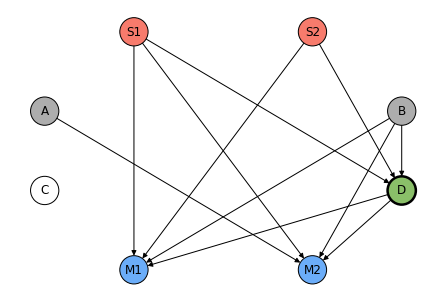

In [35]:
# for our example system in a state, there were no irreducible subsystems that would exist intrinsically if physically instantiated.
# Let's inspect the animat. Do you think it makes sense that it is reducible?

agency.plot_brain(cm)